# Invert 1D VES (Vertical Electrical Sounding) data

Stefan Nielsen, Durham UNiversity, May 2024

### this is based on pygimli examples with minor modifications:
- pygimli (www.pyglimi.org)


In [1]:
"""
VES inversion for a blocky model
================================
Use variable distances for L and l in Schlumbeger geometry
"""
###############################################################################
# We import numpy, matplotlib, pygimli for geophys modeliing and inversion and 
# pandas (optional, to read csv file)
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
from pygimli.viewer.mpl import drawModel1D
import pandas as pd

In [2]:
# Electrodes: C1       P1  P2        C2
#  alias      A        M   N         B
#             |        |   |         |
#-------------|--------|---|---------|-----
#             V        V   V         V
#
# ab2 is AB/2 distance (current electrodes) or L for Schlumberger array
# mn2 is MN/2 distance (potential electrodes) or l for Schlumberger array


In [3]:
###############################################################################
# some hypothesis on nr. of layers, and average error
nlay = 10  # number of layers
errPerc = 3.0  # relative error of 3 percent

In [4]:
''' 
electrode distances and resistance measurements
option 1: read csv file for input
file format:

MN/2 (m), AB/2 (m), R1 (ohms), R2 (ohms), R3 (ohms), R4 (ohms)
0.5,      1,        298,       298,       298,       298
0.5,      1.25,     195.3,     195.2,     195,       195.2
etc... etc...
'''
df=pd.read_csv('input_example.csv')
mn2 = np.array(df.iloc[:,0]);
ab2 = np.array(df.iloc[:,1]);
r1, r2, r3, r4 = np.array(df.iloc[:,2]), np.array(df.iloc[:,3]), np.array(df.iloc[:,4]), np.array(df.iloc[:,5])
rho = (r2+r3+r4)/3
print('mn2=',mn2) 
print('ab2=',ab2)
print('rho=',rho)
# option 2: input by hand directly:
#ab2 = np.asarray([ 1.25,   2.5,    5,   10,   20,   40])
#mn2 = np.asarray([   .5,    .5,   .5,   .5,   .5,   .5])
#rho = np.asarray([37.17, 4.097,  .35, .047, .015, .006])

mn2= [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
ab2= [ 1.    1.25  1.5   2.    2.5   3.    4.    5.    6.    7.    8.   10.
 12.   14.  ]
rho= [298.         195.13333333 141.86666667  91.9         64.2
  48.2         32.5         23.26666667  18.23333333  14.9
  12.           9.3          7.3          5.8       ]


In [5]:
''' initialize the forward modelling operator'''
f = pg.core.DC1dModelling(nlay, ab2, mn2)

In [6]:
###############################################################################
#  NOTE: from real data, the apparent resistivity is obtained
#  from resistence (rho or V/I) for schlumberger as:
#           rhoa = (np.pi/(8*mn2)) * ( (ab2-mn2)**2 - (2*mn2)**2 ) * rho
###############################################################################
rhoa=(np.pi/(8*mn2)) * ( ab2**2 - mn2**2 ) * rho
rhoa

array([175.53648952, 201.15028712, 222.84363889, 270.66784206,
       302.53537254, 331.24167541, 402.02568489, 452.27153239,
       511.95524783, 570.49359094, 600.829595  , 728.59424123,
       824.17719772, 891.70180481])

./core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
./core/src/regionManager.h:182		void GIMLI::Region::setStartValue(double)  is deprecated 
./core/src/modellingbase.cpp:554		GIMLI::RVector GIMLI::ModellingBase::createStartVector()  is deprecated 


rrms=6.39%, chi^2=5.033


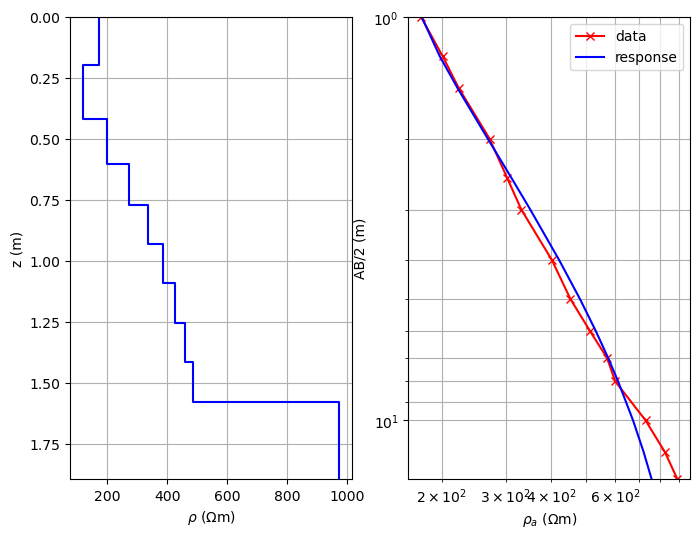

In [7]:
# create some transformations used for inversion
transThk = pg.trans.TransLog()  # log-transform ensures thk>0
transRho = pg.trans.TransLogLU(1, 1000)  # lower and upper bound
transRhoa = pg.trans.TransLog()  # log transformation for data
###############################################################################
# set model transformation for thickness and resistivity
f.region(0).setTransModel(transThk)  # 0=thickness
f.region(1).setTransModel(transRho)  # 1=resistivity
###############################################################################
# generate start model values from median app. resistivity & spread
paraDepth = max(ab2) / 3.  # rule-of-thumb for Wenner/Schlumberger
f.region(0).setStartValue(paraDepth / nlay / 2)
f.region(1).setStartValue(np.median(rhoa))
###############################################################################
#############################################################################
# set up inversion
inv = pg.core.Inversion(rhoa, f, transRhoa, False)  # data vector, fop, verbose
# could also be set by inv.setTransData(transRhoa)
###############################################################################
# set error model, regularization strength and Marquardt scheme
inv.setRelativeError(errPerc / 100.0)  # alternative: setAbsoluteError in Ohmm
lam = 200.  # (initial) regularization parameter
inv.setLambda(lam)  # (initial) regularization parameter
inv.setMarquardtScheme(0.9)  # decrease lambda by factor 0.9
model = f.createStartVector()  # creates from region start value
#model[nlay] = 1.5  # change default model by changing 2nd layer resistivity
inv.setModel(model)  #
###############################################################################
# run actual inversion and extract resistivity and thickness
model = inv.run()  # result is a pg.Vector, but compatible to numpy array
res, thk = model[nlay-1:nlay*2-1], model[0:nlay-1]
print('rrms={:.2f}%, chi^2={:.3f}'.format(inv.relrms(), inv.chi2()))
###############################################################################
# show estimated&synthetic models and data with model response in 2 subplots
fig, ax = plt.subplots(ncols=2, figsize=(8, 6))  # two-column figure
#drawModel1D(ax[0], synthk, synres, plot='semilogx', color='r')
drawModel1D(ax[0], thk, res, color='b')
ax[0].grid(True, which='both')
ax[0].set_ylabel('z (m)')
ax[0].set_xlabel(r'$\rho$ ($\Omega$m)')
ax[1].loglog(rhoa, ab2, 'rx-', label='data')  # sounding curve
ax[1].loglog(inv.response(), ab2, 'b-', label='response')
ax[1].set_ylim((max(ab2), min(ab2)))  # downwards according to penetration
ax[1].grid(True, which='both')
ax[1].set_xlabel(r'$\rho_a$ ($\Omega$m)')
ax[1].set_ylabel('AB/2 (m)')
ax[1].legend(loc='best')
plt.show()
